In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from distfit import distfit
from scipy import stats
c = pd.read_csv('../../Visualizations/color.csv')['color']

### Load Data and Find the Best Fit

In [105]:
load_growth = pd.read_csv('LoadGrowth.csv')
cols = ['year', 'electricity usage Mkh']

annual_percent = np.array([100*(load_growth[cols[1]].iloc[l] - load_growth[cols[1]].iloc[l-1])/load_growth[cols[1]].iloc[l-1] for l in range(1, len(load_growth))])

dist = distfit(alpha=0.05, bins=100)
dist.fit_transform(annual_percent +  abs(min(annual_percent)))
pd.DataFrame(dist.summary).to_csv('FittedPDFs.csv')

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.166431] [loc=10.588 scale=5.665]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.236415] [loc=0.000 scale=10.588]
[distfit] >INFO> [pareto    ] [0.0 sec] [RSS: 0.236415] [loc=-536870912.000 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 0.162471] [loc=9.851 scale=4.696]
[distfit] >INFO> [t         ] [0.15 sec] [RSS: 0.164139] [loc=10.231 scale=5.106]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 0.150187] [loc=8.093 scale=4.653]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 0.152151] [loc=-4.184 scale=2.135]
[distfit] >INFO> [lognorm   ] [0.09 sec] [RSS: 0.150907] [loc=-9.007 scale=18.823]
[distfit] >INFO> [beta      ] [0.06 sec] [RSS: 0.152068] [loc=-3.979 scale=1408764.630]
[distfit] >INFO> [uniform   ] [0.01 sec] [RSS: 0.221048] [loc=0.000 scale=27.849]
[distfit] >INFO> [loggamma  ] [0.04 sec] [RSS: 0.166368] [loc=-1854.485 scale=247.485]


In [127]:
s, loc, scale = 0.2833010289399311, -9.007077943932085, 18.8234506547371
x = np.linspace(-10, 30, 100)
best_dist = stats.lognorm(s, loc, scale).pdf(x)

### Plot the Figures

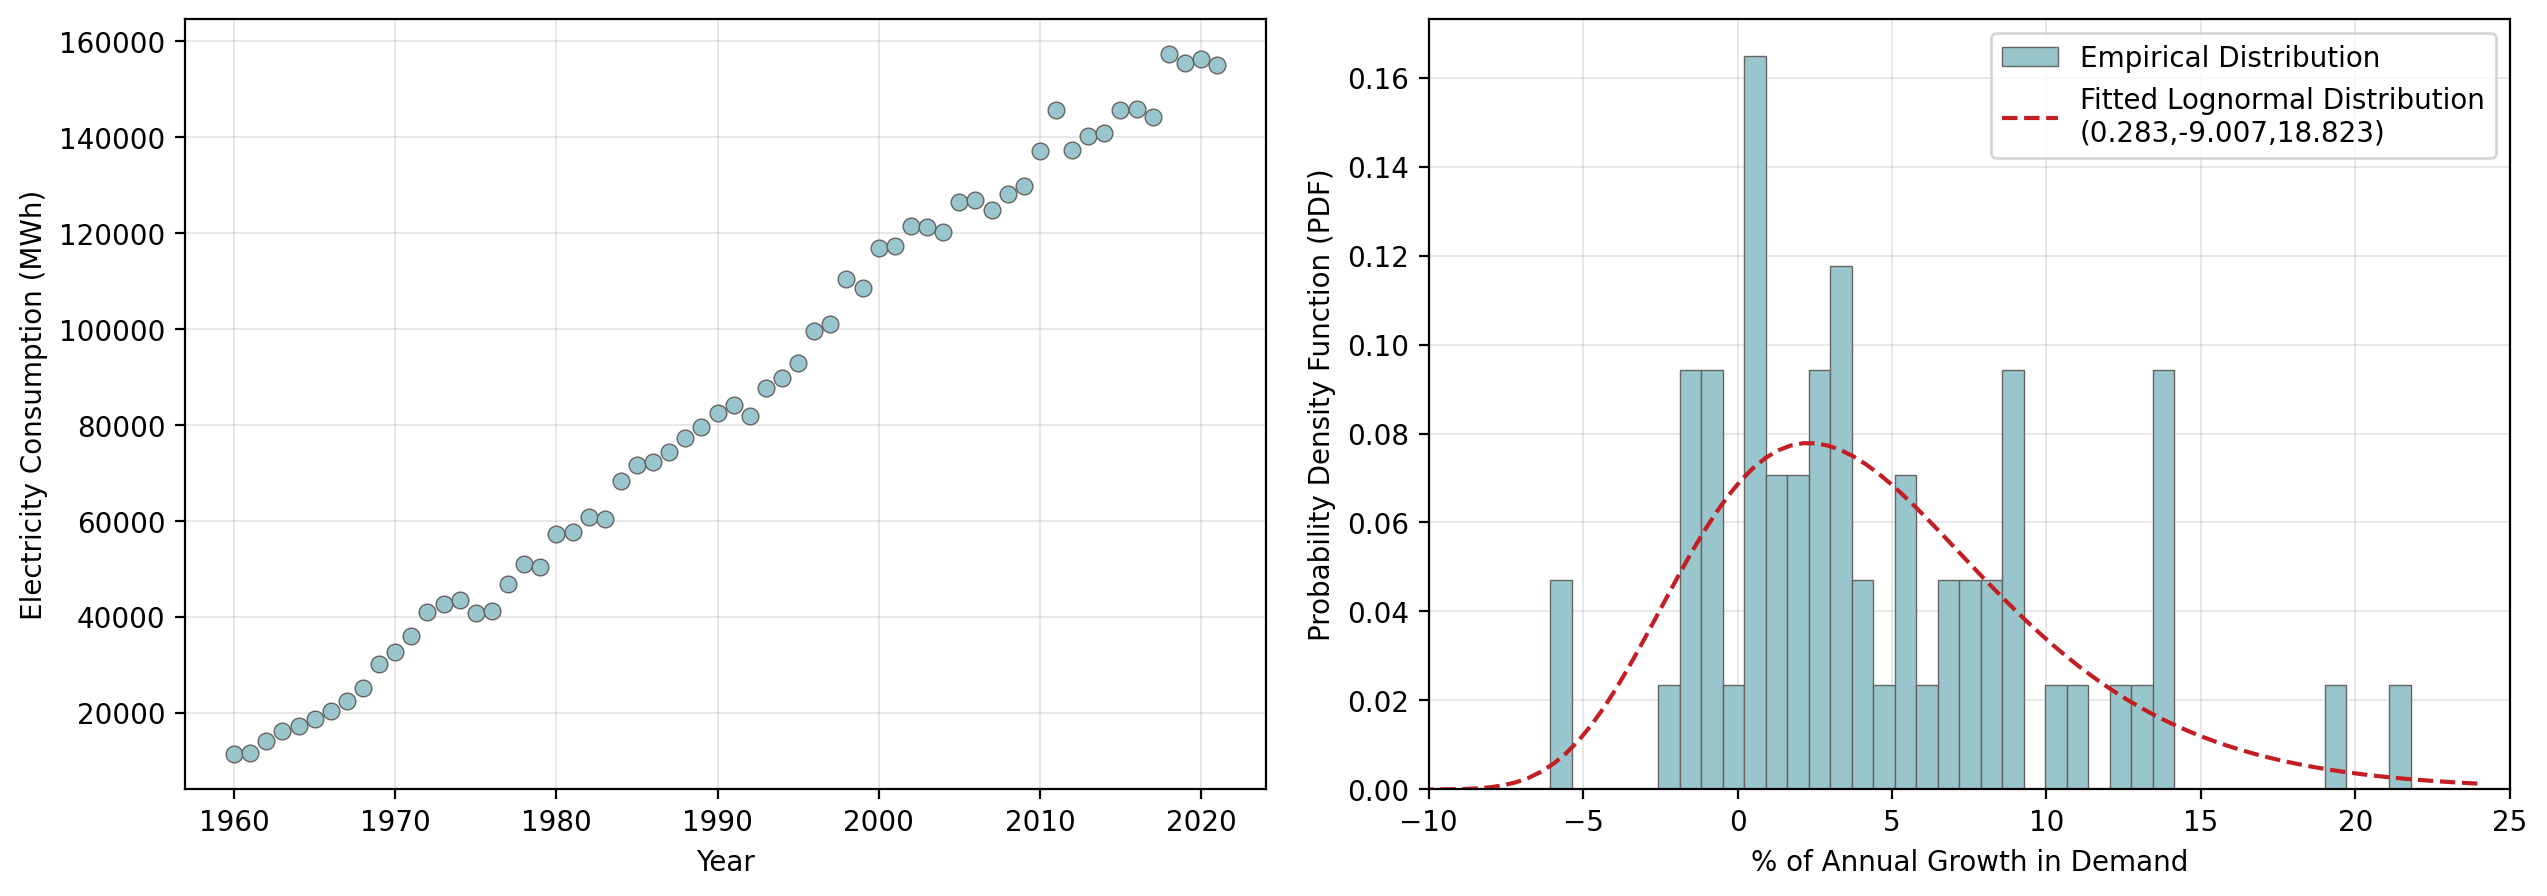

In [182]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax[0].scatter(load_growth[cols[0]], load_growth[cols[1]], color=c[1], edgecolor='#666362', linewidth=0.5)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Electricity Consumption (MWh)')
ax[0].grid(color='#666362', linestyle='-', linewidth=0.1)
ax[0].set_axisbelow(True)

ax[1].hist(annual_percent, bins=40, density=True, color=c[1], edgecolor='#666362', linewidth=0.5, label='Empirical Distribution')
ax[1].plot(x -  abs(min(annual_percent)), best_dist, linestyle='--', color=c[2], label=f'Fitted Lognormal Distribution\n({s:0.3f},{loc:0.3f},{scale:0.3f})')
ax[1].set_xlabel('% of Annual Growth in Demand')
ax[1].set_ylabel('Probability Density Function (PDF)')
ax[1].set_xticks(np.linspace(-10, 25, 8))
ax[1].set_xlim([-10, 25])
ax[1].legend()
ax[1].grid(color='#666362', linestyle='-', linewidth=0.1)
ax[1].set_axisbelow(True)
plt.subplots_adjust(wspace=0.15)
plt.savefig('AnnualDemandGrowth.jpg', bbox_inches='tight')

### Generate Scenarios

In [183]:
# Create a lognormal distribution
lognorm_dist = stats.lognorm(s, loc, scale)

# Generate random samples from the gamma distribution
lognorm_samples = lognorm_dist.rvs(1000)
lognorm_cdf = lognorm_dist.cdf(lognorm_samples)

# Transform the gamma samples to normal samples
normal_samples = stats.norm.ppf(lognorm_dist.cdf(lognorm_samples))
normal_cdf = stats.norm.cdf(normal_samples)
probs = [stats.norm.cdf(x) for x in normal_samples[0: 100]]
ranges = np.linspace(-3.5, 3.5, 8)
intervals = np.linspace(-3, 3, 7)
prob_ranges = {intervals[i]: [stats.norm.cdf(ranges[i]), stats.norm.cdf(ranges[i+1])] for i in range(len(intervals))}
range_trans = {key: stats.lognorm.ppf(stats.norm.cdf(key), s, loc, scale) for key in intervals}

scenarios = {'Norm Error': [], 'Lognorm Scenario': [], 'Probability': []}
for i in probs:
    for key in intervals:
        if prob_ranges[key][0]<= i <=prob_ranges[key][1]:
            scenarios['Norm Error'].append(key)
            scenarios['Probability'].append(prob_ranges[key][1]-prob_ranges[key][0])
            scenarios['Lognorm Scenario'].append(range_trans[key]) #  - abs(min(re)) + mean
            break
pd.DataFrame(scenarios).to_csv('Annual-Demand-Growth-Scenarios.csv')